In [19]:
import sys
import torch
import pickle
from glob import glob
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import healpy as hp

In [2]:
sys.path.append('/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/scripts')
from diffusion.diffusionclass import Diffusion
from diffusion.schedules import TimestepSampler, linear_beta_schedule
from diffusion.ResUnet_timeembed import Unet
from maploader.maploader import get_data, get_minmaxnormalized_data, get_loaders, MapDataset
from utils.filter_boost import filter_boost, calculate_k, batch_filter_boost
from utils.run_utils import initialize_config, setup_trainer

/gpfs02/work/akira.tokiwa/gpgpu/anaconda3/envs/pylit/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
config_file = "/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/config/config_diffusion.yaml"
config_dict = initialize_config(config_file)

pl.seed_everything(1234)

### get training data
lrmaps_dir = "/gpfs02/work/akira.tokiwa/gpgpu/FastPM/healpix/nc128/"
hrmaps_dir = "/gpfs02/work/akira.tokiwa/gpgpu/FastPM/healpix/nc256/"
n_maps = len(glob(lrmaps_dir + "*.fits"))
nside = 512
order = 4

CONDITIONAL = True
BATCH_SIZE = 24
TRAIN_SPLIT = 0.8

config_dict['train']['batch_size'] = BATCH_SIZE
config_dict["data"]["conditional"] = CONDITIONAL

[rank: 0] Global seed set to 1234


In [4]:
dataset_lr = MapDataset(lrmaps_dir, n_maps, nside, order)
dataset_hr = MapDataset(hrmaps_dir, n_maps, nside, order)

In [21]:
lr_np =dataset_lr.get_numpymap()

In [22]:
lr_np = hp.pixelfunc.reorder(lr_np, n2r=True)

In [ ]:
lr_np = np.exp(np.log(10) * lr_np) -1

In [28]:
lr_fft = [hp.sphtfunc.map2alm(lr_np[i], lmax=3*nside-1) for i in range(len(lr_np))]

In [29]:
lm = hp.sphtfunc.Alm.getlm(3*nside-1)

In [35]:
lr_fft_boosted = lr_fft * np.sqrt((lm[0]/lm[0].max())**2 + (lm[1]/lm[1].max())**2)

In [37]:
lr_fft_boosted.shape

(100, 1180416)

In [38]:
lr_boosted = [hp.sphtfunc.alm2map(lr_fft_boosted[i], nside=nside) for i in range(len(lr_fft_boosted))]

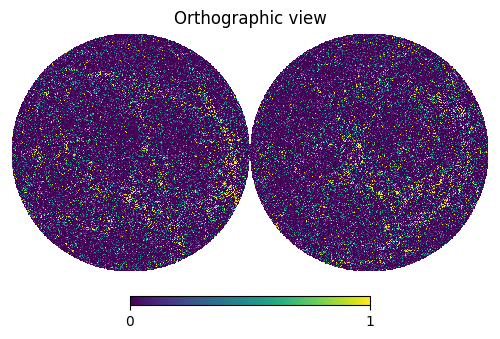

In [45]:
fig = plt.figure(figsize=(5,5))
hp.orthview(lr_boosted [0], fig=fig, min=0, max=1)

In [5]:
lr = get_data(lrmaps_dir, n_maps, nside, order, issplit=False)
hr = get_data(hrmaps_dir, n_maps, nside, order, issplit=False)

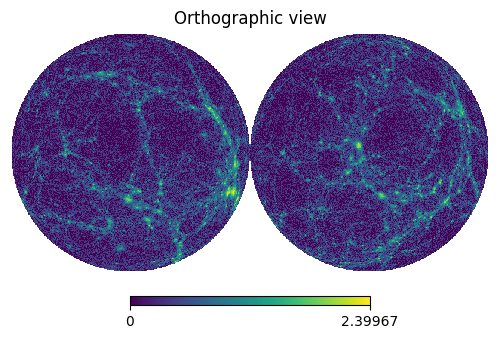

In [8]:
hr_hp = hr[0].detach().cpu().numpy().reshape(-1)
fig = plt.figure(figsize=(5,5))
hp.orthview(hr_hp, nest=True, fig=fig)

In [10]:
torch.exp(torch.log(10) * hr)

TypeError: log(): argument 'input' (position 1) must be Tensor, not int

In [17]:
lr = get_data(lrmaps_dir, n_maps, nside, order, issplit=True)
hr = get_data(hrmaps_dir, n_maps, nside, order, issplit=True)

lr, inverse_transforms_lr, range_min_lr, range_max_lr = get_minmaxnormalized_data(lr)
print("LR data loaded. min: {}, max: {}".format(range_min_lr, range_max_lr))

hr, inverse_transforms_hr, range_min_hr, range_max_hr = get_minmaxnormalized_data(hr)
print("HR data loaded. min: {}, max: {}".format(range_min_hr, range_max_hr))

data_input, data_condition = hr-lr, lr
train_loader, val_loader = get_loaders(data_input, data_condition, TRAIN_SPLIT, BATCH_SIZE)

LR data loaded. min: 0.0, max: 2.0128371715545654
HR data loaded. min: 0.0, max: 2.903632402420044


In [13]:
hr_hp = hr[0].detach().cpu().numpy().reshape(-1)

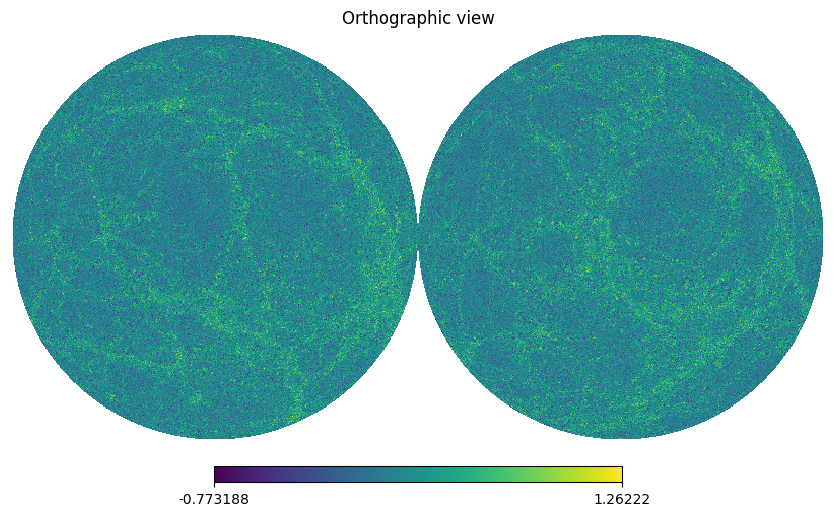

In [15]:
hp.orthview(hr_hp-lr_hp, nest=True)